In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import IMDB
from torchtext.data import Field, LabelField, BucketIterator

In [ ]:
SRC = Field(tokenize = 'spacy', lower = True)
TRG = LabelField(dtype = torch.int64)

train_data, test_data = IMDB.splits(SRC, TRG) # download imdb dataset

In [ ]:
# display lenght of test and traing data
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

In [ ]:
# display single example at index 0
print(vars(train_data.examples[0]))

In [ ]:
# Build vocabulary for source and target from training data

SRC.build_vocab(train_data, max_size=10000, min_freq=5, vectors="glove.6B.100d")  # using pretrained word embedding
TRG.build_vocab(train_data, min_freq = 5)

print(vars(TRG.vocab))
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in TRG vocabulary: {len(TRG.vocab)}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 100

# train and test iteartor
train_iterator,test_iterator = BucketIterator.splits(
      (train_data, test_data), 
      batch_size = BATCH_SIZE, 
      device = device
    )

### RNN/GRU Model Architecture
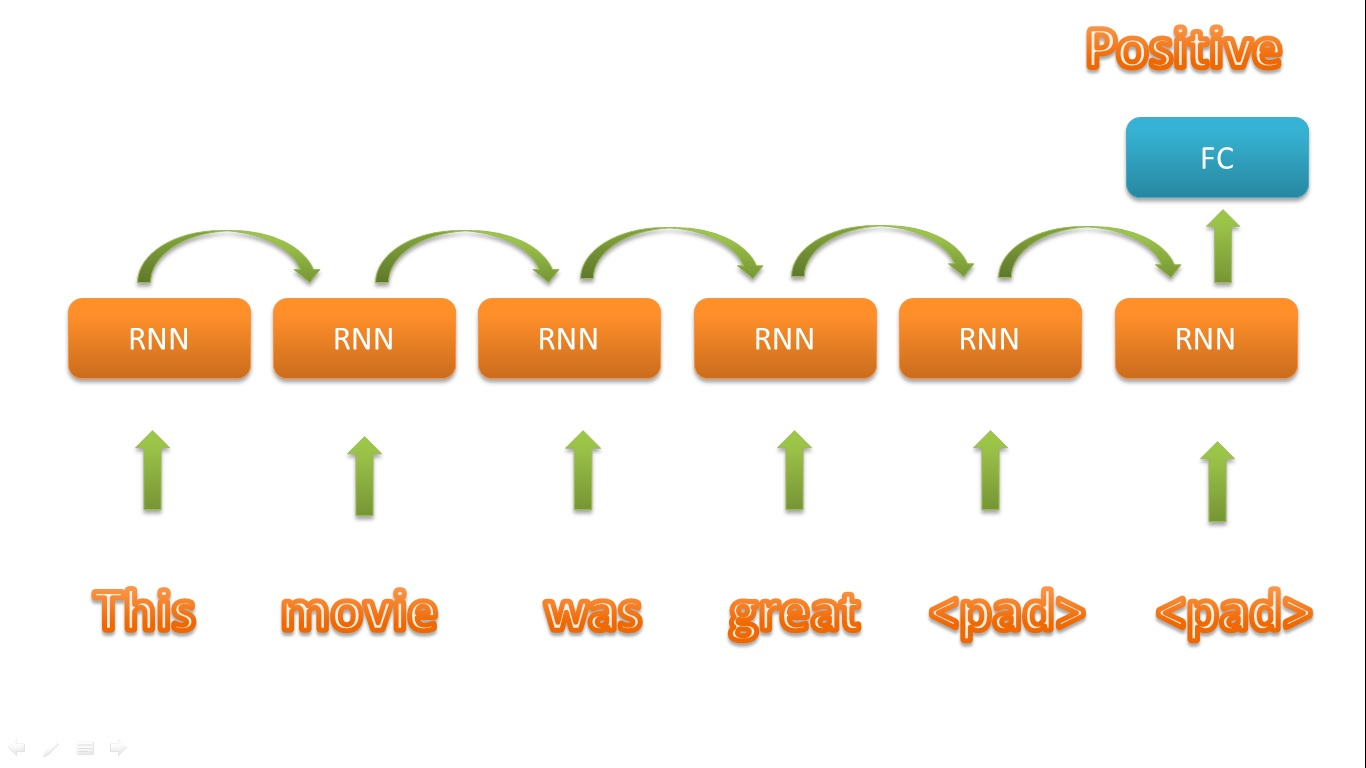

In [ ]:
# Model class
class Model(nn.Module):
  def __init__(self, input_dim, output_dim,emb_dim, hidden_dim, n_layers, dropout):
    # input_dim <--- vocabulary size
    # output_dim <--- len ([positive, negative]) == 2 
    # emb_dim <--- embedding dimension of embedding matrix
    
    super(Model, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    
    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout)
    
    self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
    self.fc2 = nn.Linear(hidden_dim//2, output_dim)
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    # shape: [source_len, batch_size]
    embedded = self.dropout(self.embedding(src)) # sahpe: [src_len, batch_size, embed_dim]
    output, hidden = self.rnn(embedded) 
    # output[batch, hidden_dim]
    # hiddden[n_layers, batch, hidden_dim]
    output = self.fc1(output[-1])
    output = self.fc2(self.relu(output))
    return output

In [ ]:
#initializing variables and hyper parameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# initializing our model
model = Model(INPUT_DIM, OUTPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)

# loading pretrained word embedding
model.embedding.weight.data.copy_(SRC.vocab.vectors) 

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# defining learnig rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()


# Model training function
def train(model, iterator, optimizer=optimizer, criterion=criterion, clip=1):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_count = 0
    
    for i, batch in enumerate(iterator):
        src = batch.text.to(device)
        trg = batch.label.to(device)
        optimizer.zero_grad()
        output = model(src)
        
        total_correct += torch.sum(torch.eq(output.argmax(1), trg))
        total_count+=len(trg)
        
        loss = criterion(output, trg)
        
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    print(f'corrent: {total_correct}/{total_count}')
    mean_loss = epoch_loss / len(iterator)
    scheduler.step(mean_loss)
    return mean_loss # mean loss

In [ ]:
# loop and train our model
total_epoch = 120
for epoch in range(total_epoch):
  result = train(model=model, iterator=train_iterator)
  print(f'Epoch {epoch} -->', result)

In [ ]:
# function to experiment movie review sentences
import spacy

!python -m spacy download en # dwonload english from spacy

sp = spacy.load('en')


def predict(sentence):

  if type(sentence) == str:
    tokanized_sentence = [word.text for word in sp.tokenizer(sentence)]
  else:
    tokanized_sentence = sentence


  input_data = [SRC.vocab.stoi[word.lower()] for word in tokanized_sentence]
  input_data = torch.tensor(input_data, dtype=torch.int64).unsqueeze(1).to(device)


  model.eval()
  output = model(input_data)
  # print(output)
  predict = output.argmax(1)
  predict = predict.squeeze(0)
  print(output)

  if predict>0:
    return "---->> Positive Review"
  else:
    return '---->> Negative Review'

In [ ]:
predict('i have enjoyed this movie') # predict funciton will predict if this is positive or negative review.